# VGG-11 实现

In [2]:
!pip install d2l

     |████████████████████████████████| 83 kB 1.3 MB/s 


In [3]:
import torch
from torch import nn
from d2l import torch as d2l

In [4]:
d2l.try_gpu()

device(type='cuda', index=0)

In [5]:
def vgg_block(num_layers, in_channels, out_channels):
    block = []
    for i in range(num_layers):
        block.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
        block.append(nn.ReLU())
        in_channels=out_channels
    block.append(nn.MaxPool2d(kernel_size=2, stride=2))
    return nn.Sequential(*block)

In [6]:
vgg_block(3, 10, 12)

Sequential(
  (0): Conv2d(10, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU()
  (4): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): ReLU()
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [7]:
conv_arch = ((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))

In [20]:
def vgg(conv_arch):
    in_channels = 1
    vgg_blk = []
    for num_layers, out_channels in conv_arch:
        vgg_blk.append(vgg_block(num_layers, in_channels, out_channels))
        in_channels = out_channels
    return nn.Sequential(*vgg_blk, 
                         nn.Flatten(),
                         nn.Linear(out_channels * 7 * 7, 4096),
                         nn.ReLU(),
                         nn.Dropout(0.5),
                        #  nn.Linear(4096, 4096),
                        #  nn.ReLU(),
                        #  nn.Dropout(0.5),
                         nn.Linear(4096, 10)
                         )

In [9]:
net = vgg(conv_arch)

In [10]:
X = torch.rand(size=(1, 1, 224, 224))
for blk in net:
    X = blk(X)
    print(blk.__class__.__name__,'Output Shape: ',X.shape)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Sequential Output Shape:  torch.Size([1, 64, 112, 112])
Sequential Output Shape:  torch.Size([1, 128, 56, 56])
Sequential Output Shape:  torch.Size([1, 256, 28, 28])
Sequential Output Shape:  torch.Size([1, 512, 14, 14])
Sequential Output Shape:  torch.Size([1, 512, 7, 7])
Flatten Output Shape:  torch.Size([1, 25088])
Linear Output Shape:  torch.Size([1, 4096])
ReLU Output Shape:  torch.Size([1, 4096])
Dropout Output Shape:  torch.Size([1, 4096])
Linear Output Shape:  torch.Size([1, 10])


In [11]:
batch_size = 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid poten

In [12]:
[(conv[0], conv[1] // 4) for conv in conv_arch]

[(1, 16), (1, 32), (2, 64), (2, 128), (2, 128)]

loss 0.132, train acc 0.951, test acc 0.929
383.6 examples/sec on cuda:0


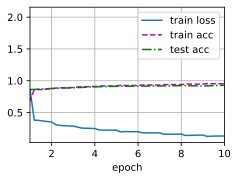

In [19]:
# 加入初始化
# 三层全连接层
def weight_init(model):
  if isinstance(model,(nn.Linear, nn.Conv2d)):
    nn.init.xavier_uniform_(model.weight)
    # nn.init.constant_(model.bias, val=0)
net = vgg([(conv[0], conv[1] // 4) for conv in conv_arch])
# net.apply(weight_init)
lr, num_epochs = 0.1, 10
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

loss 0.144, train acc 0.946, test acc 0.914
400.8 examples/sec on cuda:0


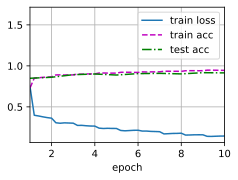

In [21]:
# 加入初始化
def weight_init(model):
  if isinstance(model,(nn.Linear, nn.Conv2d)):
    nn.init.xavier_uniform_(model.weight)
    # nn.init.constant_(model.bias, val=0)
net = vgg([(conv[0], conv[1] // 4) for conv in conv_arch])
net.apply(weight_init)
lr, num_epochs = 0.05, 10
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())